In [2]:
"""
@Description :   
@Author      :   Xubo Luo 
@Time        :   2024/08/21 10:44:24
"""

'\n@Description :   \n@Author      :   Xubo Luo \n@Time        :   2024/08/21 10:44:24\n'

## LightGlue

In [3]:
from pathlib import Path

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
import time

torch.set_grad_enabled(False)
images = Path("assets")

/home/wuaodi/anaconda3/envs/fastmatch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

/home/wuaodi/workspace/Codes/dev/FastMatch/lightglue/lightglue.py:143: UserWarning: FlashAttention is not available. For optimal speed, consider installing torch >= 2.0 or flash-attn.
  self.inner_attn = Attention(flash)


Feature extraction took 0.05 seconds
dict_keys(['keypoints', 'keypoint_scores', 'descriptors', 'image_size'])
torch.Size([1, 2048, 2]) torch.Size([1, 2048, 256])
tensor([[800., 600.]], device='cuda:0')
Matching took 0.02 seconds


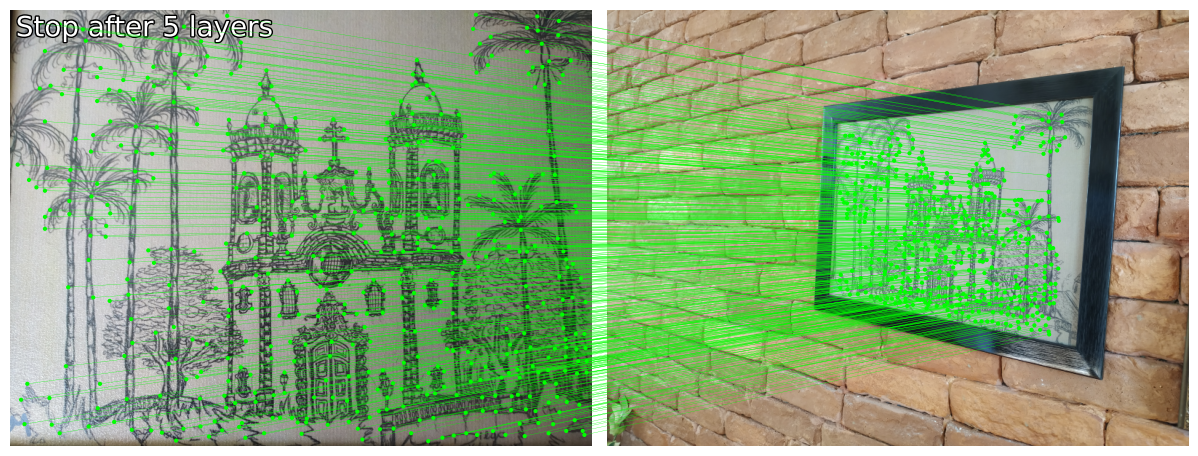

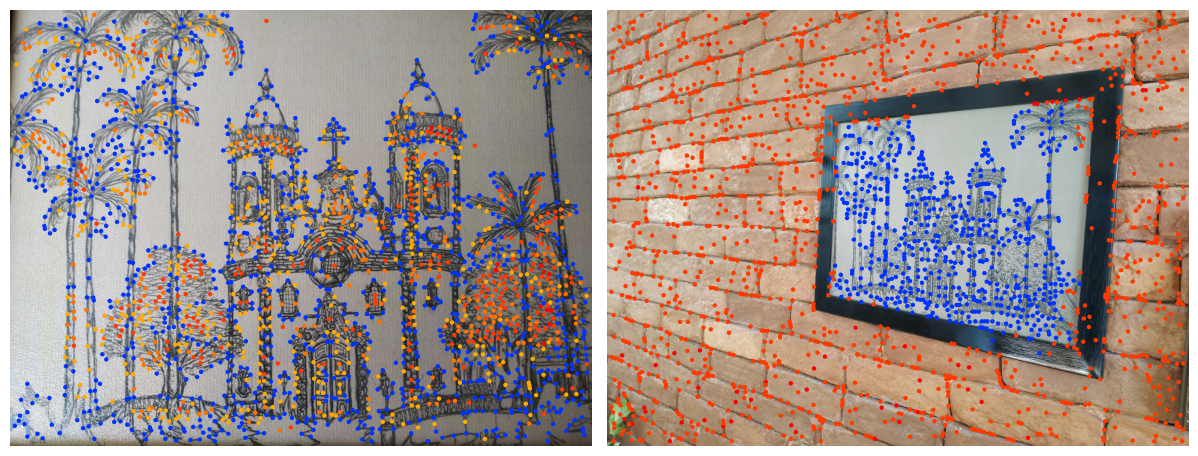

In [5]:
image0 = load_image(images / "ref.png")
image1 = load_image(images / "tgt.png")

tik = time.time()
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
tok = time.time()
print(f"Feature extraction took {tok - tik:.2f} seconds")

print(feats0.keys())
print(feats0["keypoints"].shape, feats0["descriptors"].shape)
print(feats0['image_size'])

tik = time.time()
matches01 = matcher({"image0": feats0, "image1": feats1})
tok = time.time()
print(f"Matching took {tok - tik:.2f} seconds")

feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

## XFeat

In [6]:
import numpy as np
import os
import tqdm
import cv2
import torch
import matplotlib.pyplot as plt

from xfeat.xfeat import XFeat

xfeat = XFeat()

loading weights from: /home/wuaodi/workspace/Codes/dev/FastMatch/xfeat/../weights/xfeat.pt


In [7]:
def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

In [8]:
#Load some example images
im1 = cv2.imread('./assets/ref.png')
im2 = cv2.imread('./assets/tgt.png')

In [9]:
print(im1.shape)

(600, 800, 3)


In [10]:
#Use out-of-the-box function for extraction + MNN matching
mkpts_0, mkpts_1, time1, time2 = xfeat.match_xfeat(im1, im2, top_k = 4096)

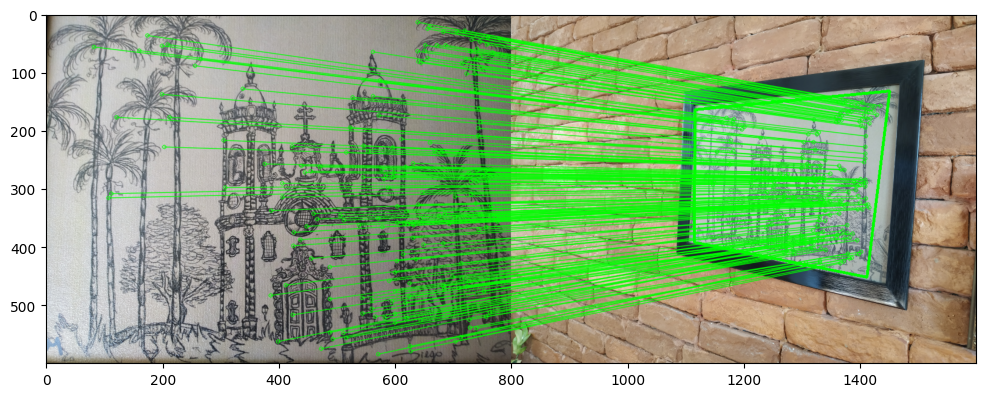

(<matplotlib.image.AxesImage at 0x7fc9f06c7130>, None)

In [11]:
canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

Detection time:  0.07136011123657227
Matching time:  0.0025284290313720703


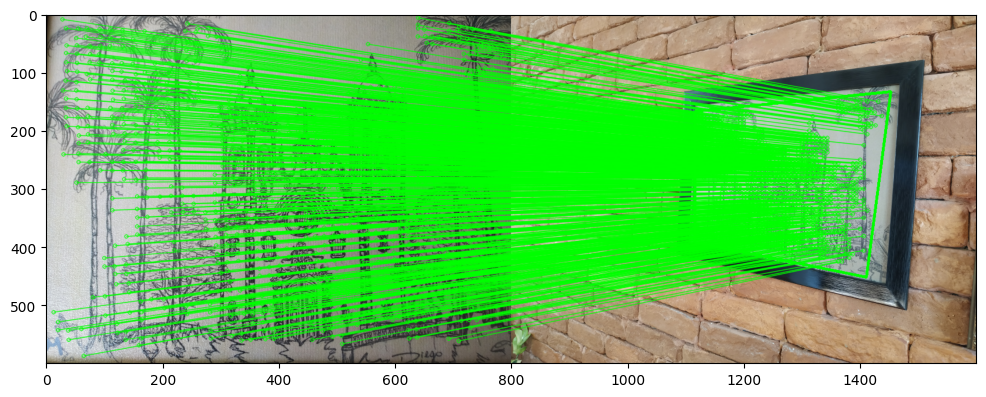

(<matplotlib.image.AxesImage at 0x7fc9f060b5b0>, None)

In [12]:
mkpts_0, mkpts_1 = xfeat.match_xfeat_star(im1, im2, top_k = 8000)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

## XFeat + LighterGlue

/home/wuaodi/anaconda3/envs/fastmatch/lib/python3.8/site-packages/kornia/feature/lightglue.py:154: UserWarning: FlashAttention is not available. For optimal speed, consider installing torch >= 2.0 or flash-attn.
  self.inner_attn = Attention(flash)


Loaded LightGlue model


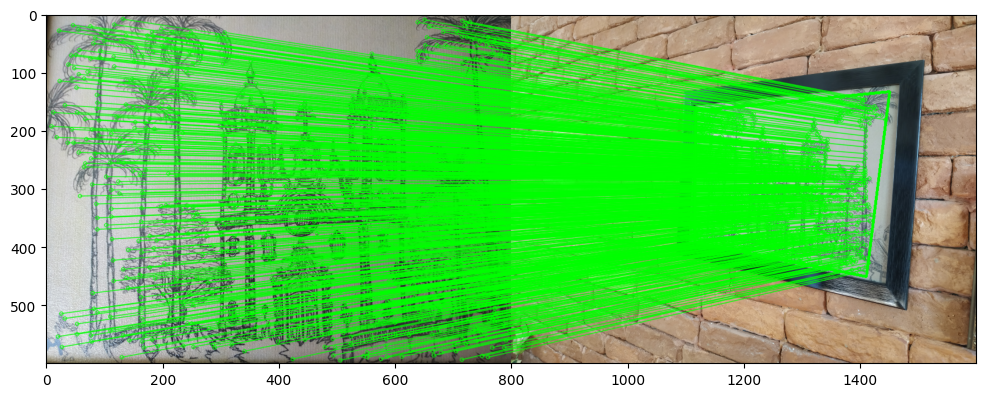

(<matplotlib.image.AxesImage at 0x7fc9f04a7580>, None)

In [13]:
im1 = cv2.imread('./assets/ref.png')
im2 = cv2.imread('./assets/tgt.png')
# im1 = xfeat.parse_input(im1)
# im2 = xfeat.parse_input(im2)

output0 = xfeat.detectAndCompute(im1, top_k = 4096)[0]
output1 = xfeat.detectAndCompute(im2, top_k = 4096)[0]

#Update with image resolution (required)
output0.update({'image_size': (im1.shape[1], im1.shape[0])})
output1.update({'image_size': (im2.shape[1], im2.shape[0])})

mkpts_0, mkpts_1 = xfeat.match_lighterglue(output0, output1)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()